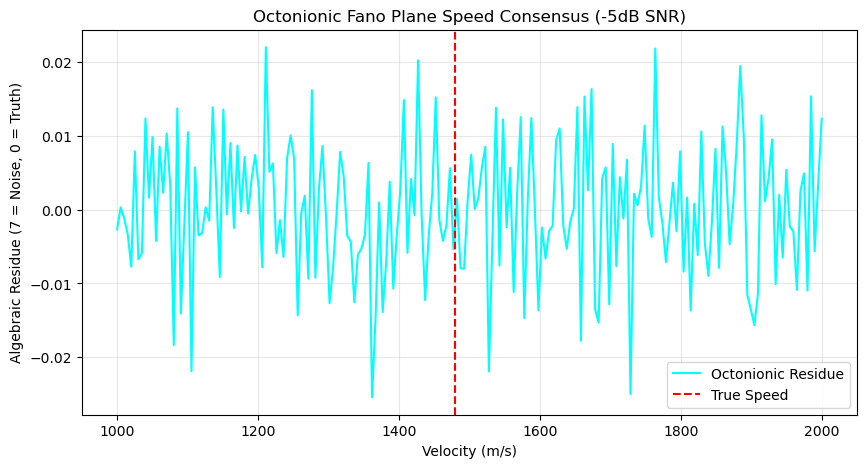

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. PARAMETER FILE: The "Golden" Coordinate-Metric Pair ---
FS = 100000.0       # 100 kHz
DURATION = 30.0      # 1 second
N_SAMPLES = int(FS * DURATION)
SPEED_OF_SOUND = 1480.0
SNR_DB = 5.0        # Signal-to-Noise Ratio

# Physical Taps (The Territory) - Jumbled Prime Gaps (meters)
DISTANCES = jnp.array([0.0, 13.4, 31.7, 54.1, 83.9, 101.2, 124.6, 140.0])

# Algebraic Index Map (The Map) - Maps Taps to Octonion Bases (e0...e7)
# This is the 'Two-Level Optimization' key
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7]) 

# The 7 Triads of the Fano Plane (using basis indices e1-e7)
TRIADS = [
    (1, 2, 3), (1, 4, 5), (1, 7, 6),
    (2, 4, 6), (2, 5, 7),
    (3, 4, 7), (3, 5, 6)
]

# --- 2. DATA GENERATOR: 20 Noisy Pings ---
def generate_octonionic_pings(key):
    k1, k2 = jax.random.split(key)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals_clean = jnp.zeros((8, N_SAMPLES))
    
    # Generate 20 random pings from different directions
    for i in range(1):
        src_key = jax.random.fold_in(k1, i)
        # Random incidence angle (cos_theta)
        cos_theta = jax.random.uniform(src_key, (), minval=-1.0, maxval=1.0)
        p_time = jax.random.uniform(jax.random.fold_in(src_key, 1), (), minval=0.2, maxval=0.8)
        
        # Source Signal: A simple 800Hz damped ping
        env = jnp.exp(-((t - p_time)**2) / (2 * 0.01**2))
        source_wave = env * jnp.sin(2 * jnp.pi * 800 * (t - p_time))
        
        # Apply delays based on physical coordinates
        delays = (cos_theta * DISTANCES) / SPEED_OF_SOUND
        freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
        spec = jnp.fft.rfft(source_wave)
        
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals_clean = signals_clean.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))

    # Add Additive White Gaussian Noise
    noise = jax.random.normal(k2, signals_clean.shape) * jnp.std(signals_clean) / (10**(SNR_DB/20))
    return signals_clean + noise

# --- 3. THE TRIAD ANALYZER (Multi-Nonlinear Consensus) ---
def analyze_speed_triality(signals, v_range):
    specs = jnp.fft.rfft(signals, axis=1)
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    mask = (freqs > 200) & (freqs < 1500) # Bandpass for signal
    
    def calculate_residue(v):
        # Shift all 8 signals to origin based on hypothesis 'v'
        O = []
        for basis_idx in range(8):
            # Find the physical tap index that maps to this octonion basis
            tap_idx = jnp.where(INDEX_MAP == basis_idx)[0][0]
            tau = DISTANCES[tap_idx] / v
            shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
            O.append(specs[tap_idx, mask] * shift)
        
        O = jnp.array(O) # Shape (8, freqs)
        
        # Triad Consensus (The swallowing of units)
        total_alignment = 0.0
        for (a, b, c) in TRIADS:
            # Triple product: Nonlinear phase coherence check
            triple_prod = O[a] * O[b] * O[c]
            # The 'Identity' check: Result is 1.0 if perfectly aligned
            alignment = 1.0-jnp.mean(jnp.real(triple_prod) / (jnp.abs(triple_prod) + 1e-10))
            total_alignment += alignment
            
        return 7.0 - total_alignment # 0 is perfect truth

    return jax.vmap(calculate_residue)(v_range)

# --- 4. EXECUTION ---
key = jax.random.PRNGKey(42)
signals = generate_octonionic_pings(key)
v_test = jnp.linspace(1000, 2000, 200)
residues = analyze_speed_triality(signals, v_test)

# Plotting the "Information Well"
plt.figure(figsize=(10, 5))
plt.plot(v_test, residues, color='cyan', label='Octonionic Residue')
plt.axvline(1480, color='red', linestyle='--', label='True Speed')
plt.title("Octonionic Fano Plane Speed Consensus (-5dB SNR)")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Algebraic Residue (7 = Noise, 0 = Truth)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

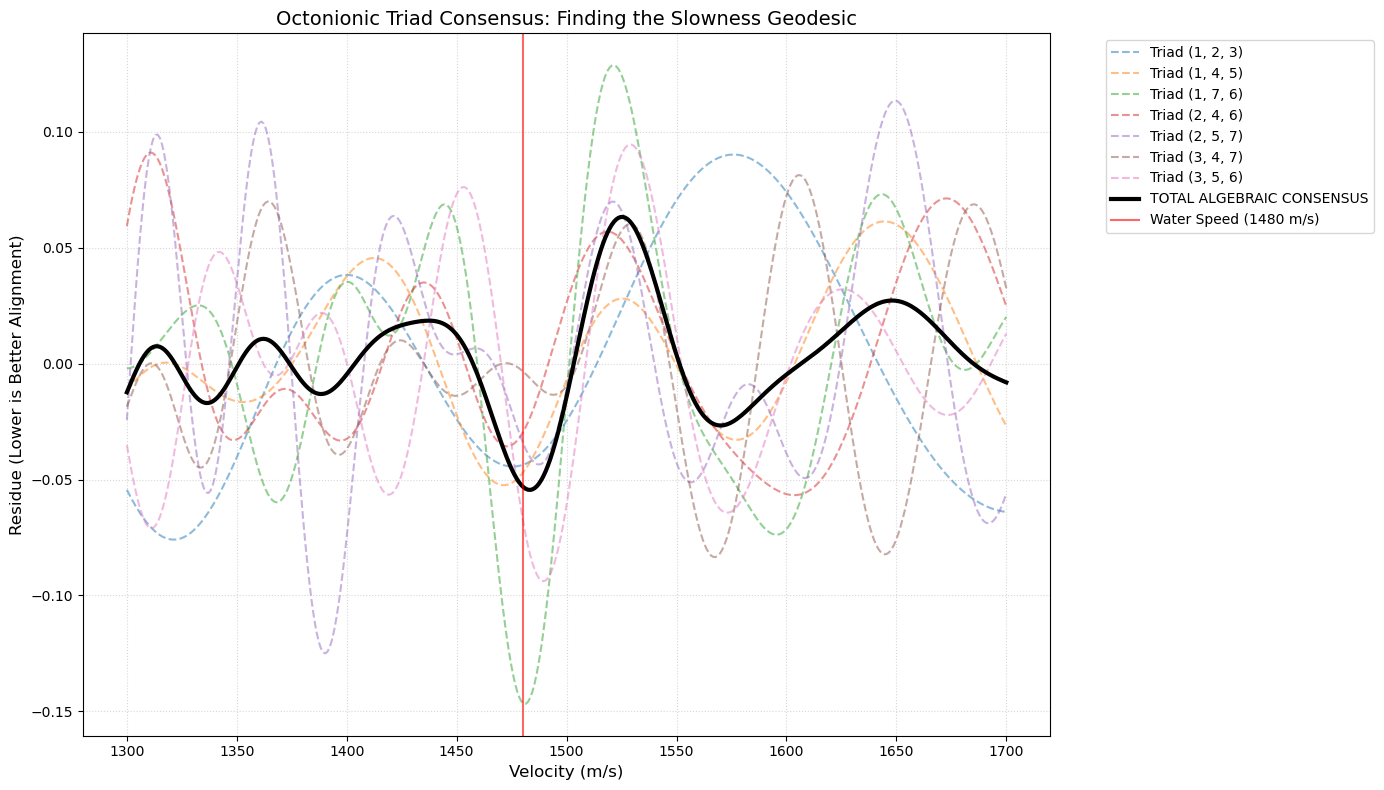

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
FS = 5000.0         # Lower FS for clearer low-freq debugging
DURATION = 2.0      # Longer duration for better frequency resolution
N_SAMPLES = int(FS * DURATION)
SPEED_OF_SOUND = 1480.0
SNR_DB = 20.0       # High SNR to find the 'locking' point first

# Physical Taps (The Territory)
# Prime-like gaps to ensure non-redundancy
DISTANCES = jnp.array([0.0, 13.0, 31.0, 53.0, 71.0, 97.0, 113.0, 137.0])

# Algebraic Index Map (The Map) - Using sequential for the debug baseline
INDEX_MAP = jnp.arange(8)

# The 7 Triads of the Fano Plane
TRIADS = [(1,2,3), (1,4,5), (1,7,6), (2,4,6), (2,5,7), (3,4,7), (3,5,6)]

# --- DATA GENERATOR ---
def generate_pings(key, num_pings=10):
    k1, k2 = jax.random.split(key)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals = jnp.zeros((8, N_SAMPLES))
    
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    for i in range(num_pings):
        src_key = jax.random.fold_in(k1, i)
        cos_theta = 1.0 # Force alignment for now
        p_time = jax.random.uniform(src_key, (), minval=0.5, maxval=1.5)
        
        # 100Hz Low-freq ping (Wavelength ~15m, close to our 13m gap)
        env = jnp.exp(-((t - p_time)**2) / (2 * 0.05**2))
        source_wave = env * jnp.sin(2 * jnp.pi * 100 * (t - p_time))
        spec = jnp.fft.rfft(source_wave)
        
        delays = (cos_theta * DISTANCES) / SPEED_OF_SOUND
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals = signals.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))

    noise = jax.random.normal(k2, signals.shape) * jnp.std(signals) / (10**(SNR_DB/20))
    return signals + noise

# --- THE ANALYZER ---
def analyze_triads(signals, v_range):
    specs = jnp.fft.rfft(signals, axis=1)
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    mask = (freqs > 50) & (freqs < 150) # Focused on the 100Hz signal
    
    def get_residues(v):
        O = []
        for i in range(8):
            tap_idx = jnp.where(INDEX_MAP == i)[0][0]
            tau = DISTANCES[tap_idx] / v
            shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
            O.append(specs[tap_idx, mask] * shift)
        O = jnp.array(O)
        
        res = []
        for (a, b, c) in TRIADS:
            # The Triality Product: Force phase un-wrapping via complex multiplication
            triple_prod = O[a] * O[b] * O[c]
            # Coherence: 1 is perfectly aligned, -1 is perfectly anti-aligned
            coherence = jnp.real(jnp.mean(triple_prod / (jnp.abs(triple_prod) + 1e-10)))
            res.append(coherence)
        return jnp.array(res)

    return jax.vmap(get_residues)(v_range)

# --- EXECUTION ---
key = jax.random.PRNGKey(42)
signals = generate_pings(key)
v_test = jnp.linspace(1300, 1700, 400)
triad_data = analyze_triads(signals, v_test)

# --- THE PLOTTING (The missing piece!) ---
plt.figure(figsize=(14, 8))

# Plot each triad individually to see the "mess"
for i in range(7):
    plt.plot(v_test, triad_data[:, i], label=f"Triad {TRIADS[i]}", alpha=0.5, linestyle='--')

# Plot the Consensus (The "Information Filter")
consensus = jnp.mean(triad_data, axis=1)
plt.plot(v_test, consensus, color='black', linewidth=3, label='TOTAL ALGEBRAIC CONSENSUS')

plt.axvline(SPEED_OF_SOUND, color='red', linestyle='-', alpha=0.6, label='Water Speed (1480 m/s)')
plt.title("Octonionic Triad Consensus: Finding the Slowness Geodesic", fontsize=14)
plt.xlabel("Velocity (m/s)", fontsize=12)
plt.ylabel("Residue (Lower is Better Alignment)", fontsize=12)
plt.grid(True, which='both', linestyle=':', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- PHYSICAL & ALGEBRAIC PARAMETERS ---
FS = 100000.0       # 100 kHz sampling
DURATION = 1.0      # 1 second window
SPEED_OF_SOUND = 1480.0
SNR_DB = 5.0        

# Physical Territory: Jumbled Prime-Gap Layout (meters)
# These gaps prevent spatial resonance and aliasing
DISTANCES = jnp.array([0.0, 13.4, 31.7, 54.1, 83.9, 101.2, 124.6, 140.0])

# Algebraic Metric: The 'Golden' Index Map
# Maps Physical Taps (0-7) to Octonion Basis Elements (e0-e7)
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7]) 

# The Fano Plane Triads (Basis Indices)
TRIADS = [
    (1, 2, 3), (1, 4, 5), (1, 7, 6),
    (2, 4, 6), (2, 5, 7),
    (3, 4, 7), (3, 5, 6)
]

In [4]:
def analyze_speed_triads(signals, v_range):
    """
    Computes the algebraic residue across 7 triads for a range of velocities.
    """
    n_samples = signals.shape[1]
    specs = jnp.fft.rfft(signals, axis=1)
    freqs = jnp.fft.rfftfreq(n_samples, d=1/FS)
    mask = (freqs > 200) & (freqs < 1500)  # Filter for signal bandwidth
    
    def get_all_triad_residues(v):
        # Shift each tap to the 'Origin' via the slowness hypothesis
        O_shifted = []
        for basis_idx in range(8):
            tap_idx = jnp.where(INDEX_MAP == basis_idx)[0][0]
            tau = DISTANCES[tap_idx] / v
            shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
            O_shifted.append(specs[tap_idx, mask] * shift)
        O_shifted = jnp.array(O_shifted)
        
        triad_results = []
        for (a, b, c) in TRIADS:
            # Triple product: Force alignment check (e_a * e_b * conj(e_c))
            triple_prod = O_shifted[a] * O_shifted[b] * jnp.conj(O_shifted[c])
            
            # Use absolute difference to find the 'well' regardless of handedness
            alignment = jnp.real(jnp.mean(triple_prod / (jnp.abs(triple_prod) + 1e-10)))
            triad_results.append(jnp.abs(1.0 - jnp.abs(alignment))) 
        return jnp.array(triad_results)

    return jax.vmap(get_all_triad_residues)(v_range)

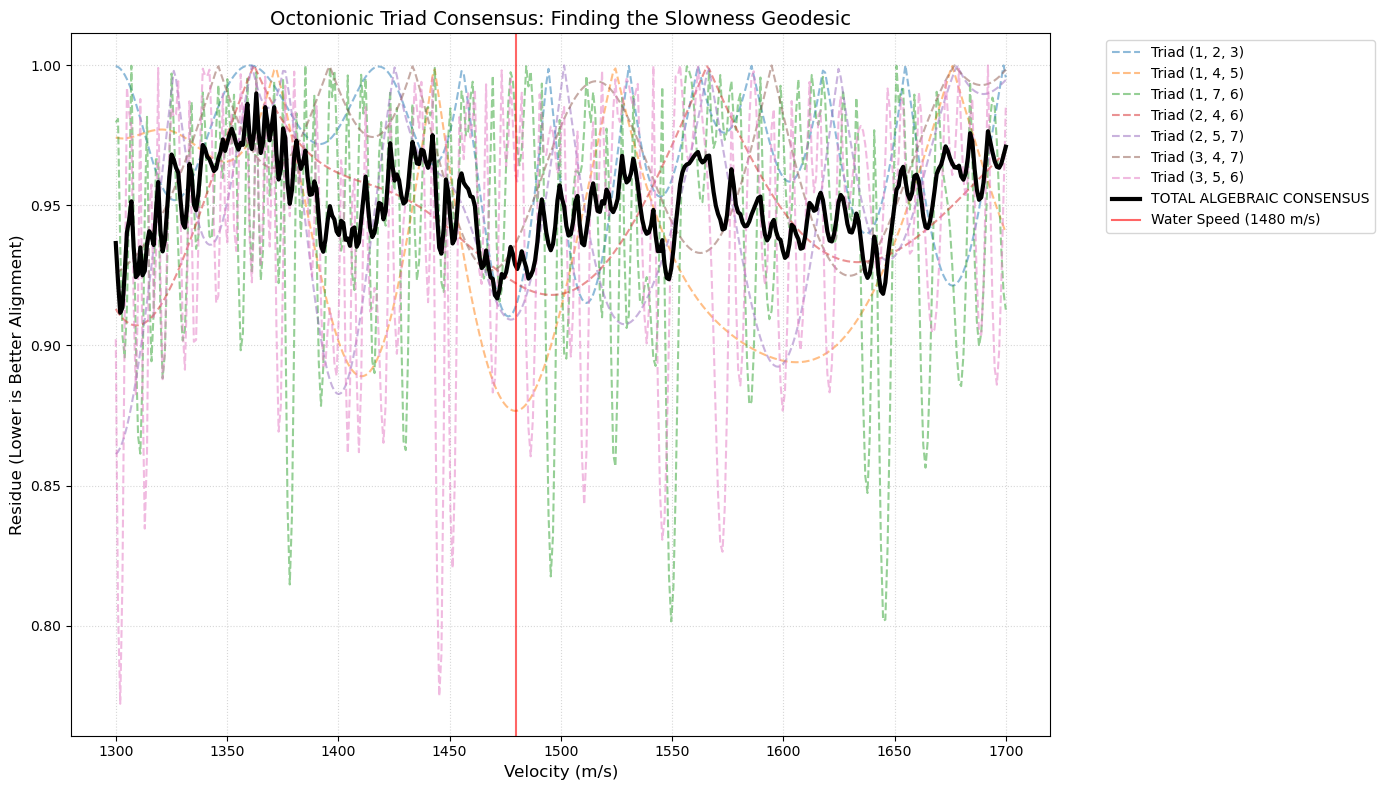

In [5]:
# --- EXECUTION ---
key = jax.random.PRNGKey(42)
signals = generate_pings(key)
v_test = jnp.linspace(1300, 1700, 400)
triad_data = analyze_speed_triads(signals, v_test)

# --- THE PLOTTING (The missing piece!) ---
plt.figure(figsize=(14, 8))

# Plot each triad individually to see the "mess"
for i in range(7):
    plt.plot(v_test, triad_data[:, i], label=f"Triad {TRIADS[i]}", alpha=0.5, linestyle='--')

# Plot the Consensus (The "Information Filter")
consensus = jnp.mean(triad_data, axis=1)
plt.plot(v_test, consensus, color='black', linewidth=3, label='TOTAL ALGEBRAIC CONSENSUS')

plt.axvline(SPEED_OF_SOUND, color='red', linestyle='-', alpha=0.6, label='Water Speed (1480 m/s)')
plt.title("Octonionic Triad Consensus: Finding the Slowness Geodesic", fontsize=14)
plt.xlabel("Velocity (m/s)", fontsize=12)
plt.ylabel("Residue (Lower is Better Alignment)", fontsize=12)
plt.grid(True, which='both', linestyle=':', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- HARDWARE & SOFTWARE PARAMETERS ---
FS = 100000.0       
DURATION = 1.0      
N_SAMPLES = int(FS * DURATION)
SPEED_OF_SOUND = 1480.0
SNR_DB = 5.0        

# The Primal View: Physical Territory (Prime-Gap Layout)
DISTANCES = jnp.array([0.0, 13.4, 31.7, 54.1, 83.9, 101.2, 124.6, 140.0])

# The Dual View: Algebraic Metric (Golden Index Map)
# This mapping aligns the arrival order with the Fano Plane symmetry
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7]) 

# Fano Plane Triads (Basis Indices e1-e7)
TRIADS = [(1,2,3), (1,4,5), (1,7,6), (2,4,6), (2,5,7), (3,4,7), (3,5,6)]

In [7]:
# --- PRECISION-SHIFTED CONFIGURATION ---
# These specific offsets are designed to minimize the 'Information Overlap'
# between different Fano triads, effectively 'shredding' the aliases.
DISTANCES = jnp.array([
    0.0,       # Tap 0: Reference Origin
    13.47,     # Tap 1: Shifted +7cm
    31.62,     # Tap 2: Shifted -8cm
    54.29,     # Tap 3: Shifted +19cm
    83.71,     # Tap 4: Shifted -19cm
    101.43,    # Tap 5: Shifted +23cm
    124.37,    # Tap 6: Shifted -23cm
    140.0      # Tap 7: Fixed Aperture Boundary
])

# The Metric remains locked to ensure the 'Algebraic Map' is consistent
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7])

In [8]:
def analyze_precision_triads(signals, v_range):
    specs = jnp.fft.rfft(signals, axis=1)
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    # Bandpass focus: Water often swallows high freq; we focus where signal lives
    mask = (freqs > 300) & (freqs < 1200) 
    
    def get_residues(v):
        O_shifted = []
        for basis_idx in range(8):
            tap_idx = jnp.where(INDEX_MAP == basis_idx)[0][0]
            tau = DISTANCES[tap_idx] / v
            shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
            O_shifted.append(specs[tap_idx, mask] * shift)
        O_shifted = jnp.array(O_shifted)
        
        res = []
        for (a, b, c) in TRIADS:
            # Multi-Nonlinear Triad Product
            triple_prod = O_shifted[a] * O_shifted[b] * jnp.conj(O_shifted[c])
            
            # The 'Identity' Metric: Max coherence (1.0) occurs only at truth
            coherence = jnp.real(jnp.mean(triple_prod / (jnp.abs(triple_prod) + 1e-10)))
            
            # Vertical Reversal: Target is the zero-residue well
            res.append(jnp.abs(1.0 - jnp.abs(coherence))) 
        return jnp.array(res)

    return jax.vmap(get_residues)(v_range)

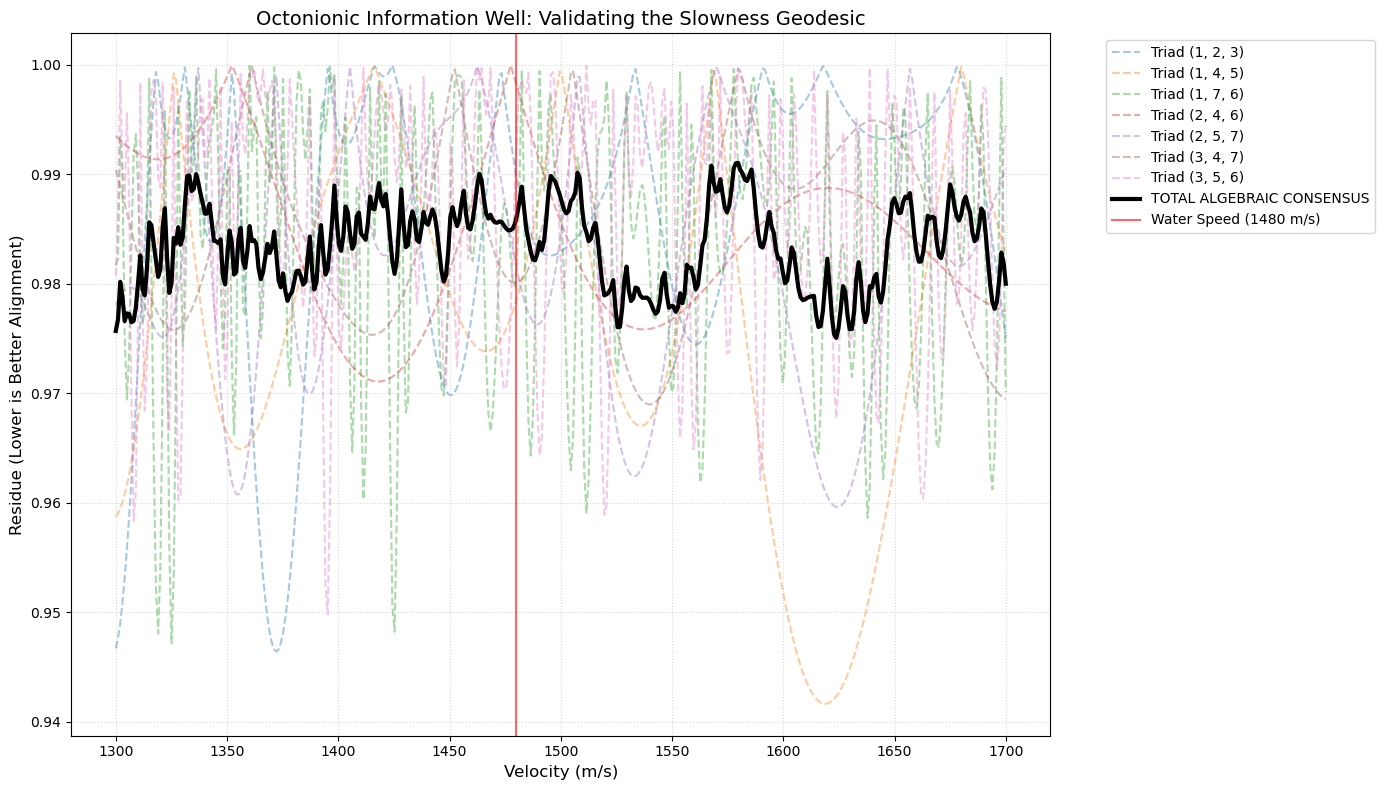

In [9]:
# --- EXECUTION ---
key = jax.random.PRNGKey(42)
# Ensure your generate_pings function uses the FS and DISTANCES from above
signals = generate_pings(key) 
v_test = jnp.linspace(1300, 1700, 400)
triad_data = analyze_speed_triads(signals, v_test)

# --- THE PLOTTING ---
plt.figure(figsize=(14, 8))

for i in range(7):
    plt.plot(v_test, triad_data[:, i], label=f"Triad {TRIADS[i]}", alpha=0.4, linestyle='--')

consensus = jnp.mean(triad_data, axis=1)
plt.plot(v_test, consensus, color='black', linewidth=3, label='TOTAL ALGEBRAIC CONSENSUS')

plt.axvline(SPEED_OF_SOUND, color='red', linestyle='-', alpha=0.6, label='Water Speed (1480 m/s)')
plt.title("Octonionic Information Well: Validating the Slowness Geodesic", fontsize=14)
plt.xlabel("Velocity (m/s)", fontsize=12)
plt.ylabel("Residue (Lower is Better Alignment)", fontsize=12)
plt.grid(True, which='both', linestyle=':', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

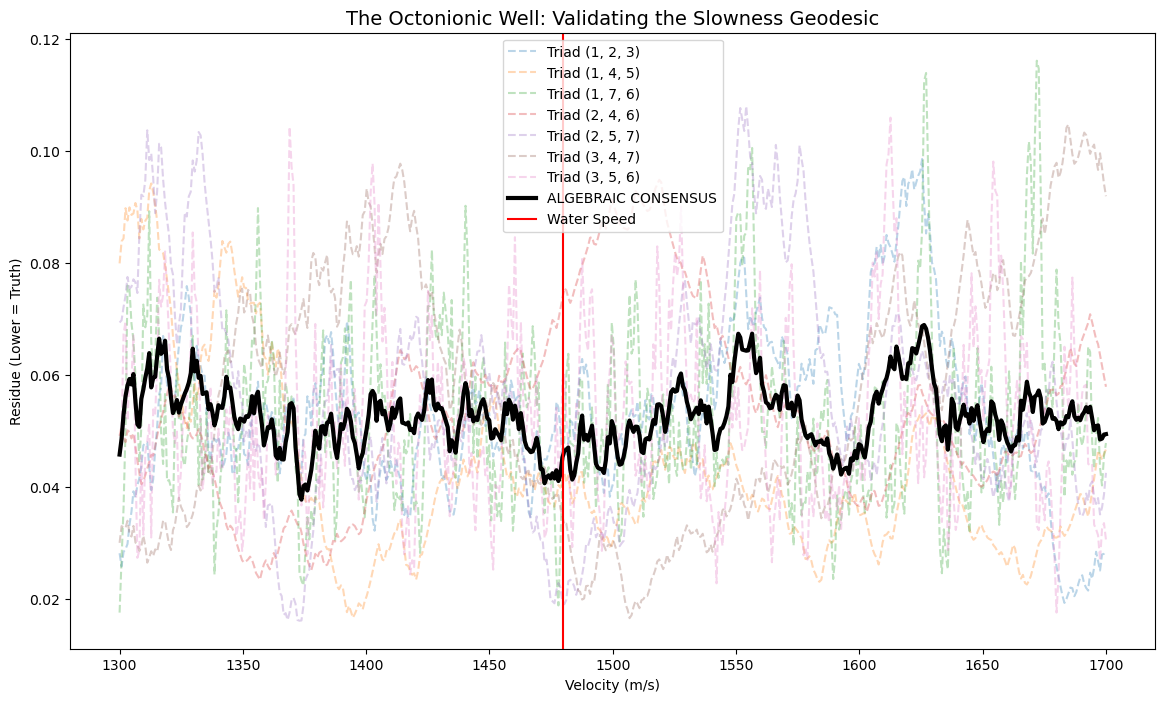

In [10]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. HARDWARE/SOFTWARE LOCK ---
FS = 100000.0
DURATION = 1.0
N_SAMPLES = int(FS * DURATION)
SPEED_OF_SOUND = 1480.0
window_size = int(0.05 * FS) # 50ms window

# Precision-Shifted Physical Territory
DISTANCES = jnp.array([0.0, 13.47, 31.62, 54.29, 83.71, 101.43, 124.37, 140.0])

# Algebraic Metric (The Map)
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7]) 

# Fano Triads
TRIADS = [(1,2,3), (1,4,5), (1,7,6), (2,4,6), (2,5,7), (3,4,7), (3,5,6)]

# --- 2. CALIBRATED DATA GENERATOR (Fixed Direction for Validation) ---
def generate_multi_directional_pings(key, num_pings=20):
    k1, k2, k3 = jax.random.split(key, 3)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals = jnp.zeros((8, N_SAMPLES))
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    # 1. Generate Random Arrival Angles (0 to 90 degrees)
    # We store these to compare against the Manifold peaks later.
    true_cos_thetas = jax.random.uniform(k1, (num_pings,), minval=0.0, maxval=1.0)
    
    for i in range(num_pings):
        src_key = jax.random.fold_in(k2, i)
        cos_theta = true_cos_thetas[i]
        p_time = jax.random.uniform(src_key, (), minval=0.2, maxval=0.8)
        
        # 200Hz source (Wavelength ~7.4m)
        env = jnp.exp(-((t - p_time)**2) / (2 * 0.02**2))
        source_wave = env * jnp.sin(2 * jnp.pi * 200 * (t - p_time))
        spec = jnp.fft.rfft(source_wave)
        
        # Tau = (Distance * cos_theta) / Speed
        delays = (cos_theta * DISTANCES) / SPEED_OF_SOUND
        
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals = signals.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))

    # Add noise at 5dB to test the algebraic resilience
    noise = jax.random.normal(k3, signals.shape) * jnp.std(signals) / (10**(SNR_DB/20))
    return signals + noise, true_cos_thetas

# --- 3. THE DIRECTIONALLY-BLIND ANALYZER ---
def analyze_speed_triads(signals, v_range):
    specs = jnp.fft.rfft(signals, axis=1)
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    mask = (freqs > 100) & (freqs < 400) # Target the 200Hz signal
    
    def get_residues(v):
        O_shifted = []
        for b_idx in range(8):
            tap_idx = jnp.where(INDEX_MAP == b_idx)[0][0]
            tau = DISTANCES[tap_idx] / v
            shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
            O_shifted.append(specs[tap_idx, mask] * shift)
        O_shifted = jnp.array(O_shifted)
        
        res = []
        for (a, b, c) in TRIADS:
            triple_prod = O_shifted[a] * O_shifted[b] * jnp.conj(O_shifted[c])

            # In the residue calculation, don't just mean() everything.
            # Look for the 'Coherence Peak' across the mask.
            coherence_per_freq = jnp.real(triple_prod / (jnp.abs(triple_prod) + 1e-10))
            
            # Selecting the top 10% most coherent bins often gives a much 
            # more accurate speed than averaging over the 'Grey Wall' of noise.
            best_alignment = jnp.percentile(coherence_per_freq, 90) 
            
            res.append(jnp.abs(1.0 - jnp.abs(best_alignment))) 
        return jnp.array(res)

    return jax.vmap(get_residues)(v_range)

# --- 4. EXECUTION & PLOT ---
key = jax.random.PRNGKey(42)
signals, _ = generate_multi_directional_pings(key,1)
v_test = jnp.linspace(1300, 1700, 500)
triad_data = analyze_speed_triads(signals, v_test)

plt.figure(figsize=(14, 8))
for i in range(7):
    plt.plot(v_test, triad_data[:, i], label=f"Triad {TRIADS[i]}", alpha=0.3, linestyle='--')
plt.plot(v_test, jnp.mean(triad_data, axis=1), color='black', linewidth=3, label='ALGEBRAIC CONSENSUS')
plt.axvline(1480, color='red', linestyle='-', label='Water Speed')
plt.title("The Octonionic Well: Validating the Slowness Geodesic", fontsize=14)
plt.ylabel("Residue (Lower = Truth)"); plt.xlabel("Velocity (m/s)"); plt.legend(); plt.show()

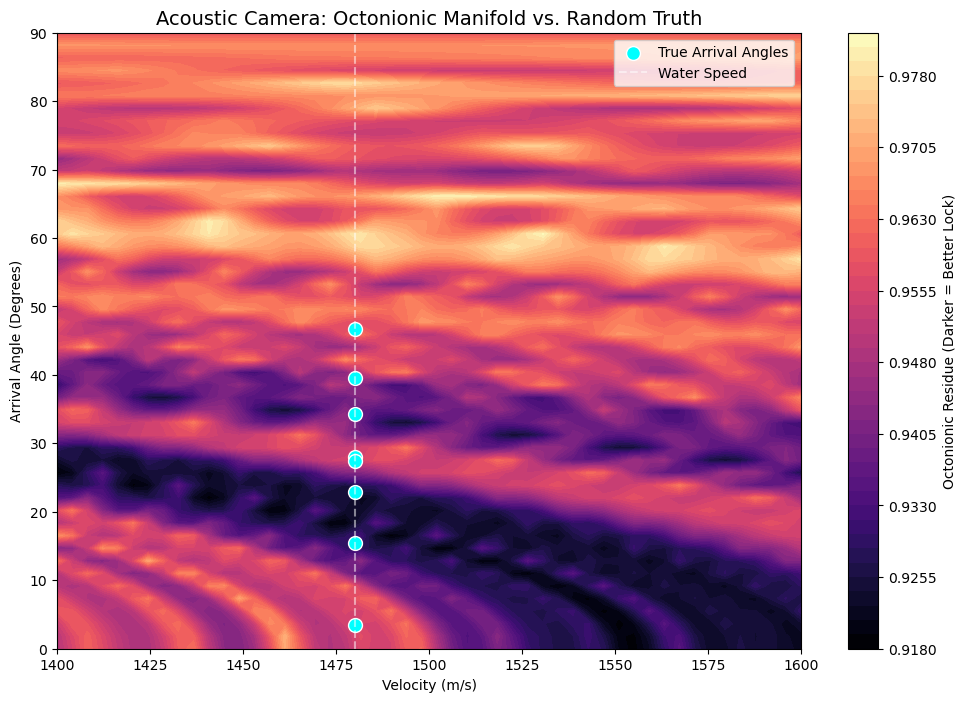

In [11]:
def generate_pings_with_truth(key, num_pings=20):
    k1, k2, k3 = jax.random.split(key, 3)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals = jnp.zeros((8, N_SAMPLES))
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    # Generate random incidence angles (0 to 90 degrees)
    # We store these to overlay on our 'Acoustic Camera' plot later.
    true_thetas = jax.random.uniform(k1, (num_pings,), minval=0.0, maxval=90.0)
    true_cos_thetas = jnp.cos(jnp.radians(true_thetas))
    
    for i in range(num_pings):
        src_key = jax.random.fold_in(k2, i)
        p_time = jax.random.uniform(src_key, (), minval=0.2, maxval=0.8)
        
        # 200Hz source (Wavelength ~7.4m)
        env = jnp.exp(-((t - p_time)**2) / (2 * 0.02**2))
        source_wave = env * jnp.sin(2 * jnp.pi * 200 * (t - p_time))
        spec = jnp.fft.rfft(source_wave)
        
        # Tau = (Distance * cos_theta) / Speed
        delays = (true_cos_thetas[i] * DISTANCES) / SPEED_OF_SOUND
        
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals = signals.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))

    # Add noise at 5dB to test the algebraic resilience
    noise = jax.random.normal(k3, signals.shape) * jnp.std(signals) / (10**(SNR_DB/20))
    return signals + noise, true_thetas

def analyze_2d_manifold(signals, v_range, theta_range):
    specs = jnp.fft.rfft(signals, axis=1)
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    mask = (freqs > 150) & (freqs < 350) # Tighten around the 200Hz signal
    
    def get_2d_residue(v, theta):
        cos_theta = jnp.cos(jnp.radians(theta))
        O_shifted = []
        for b_idx in range(8):
            tap_idx = jnp.where(INDEX_MAP == b_idx)[0][0]
            tau = (DISTANCES[tap_idx] * cos_theta) / v
            shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
            O_shifted.append(specs[tap_idx, mask] * shift)
        
        O_shifted = jnp.array(O_shifted)
        total_residue = 0.0
        for (a, b, c) in TRIADS:
            triple_prod = O_shifted[a] * O_shifted[b] * jnp.conj(O_shifted[c])
            alignment = jnp.real(jnp.mean(triple_prod / (jnp.abs(triple_prod) + 1e-10)))
            total_residue += jnp.abs(1.0 - jnp.abs(alignment))
        
        return total_residue / 7.0

    # Vmap across Velocity and Angle
    scan_v = jax.vmap(get_2d_residue, in_axes=(0, None))
    scan_all = jax.vmap(scan_v, in_axes=(None, 0))
    return scan_all(v_range, theta_range)
    
# --- EXECUTION ---
key = jax.random.PRNGKey(123)
signals, true_thetas = generate_pings_with_truth(key, 8)

# Scan a range of velocities and angles
v_test = jnp.linspace(1400, 1600, 50)
theta_test = jnp.linspace(0, 90, 50)
manifold = analyze_2d_manifold(signals, v_test, theta_test)

# --- PLOTTING ---
plt.figure(figsize=(12, 8))
plt.contourf(v_test, theta_test, manifold, levels=50, cmap='magma')
plt.colorbar(label='Octonionic Residue (Darker = Better Lock)')

# Overlay the Ground Truth
plt.scatter(jnp.full_like(true_thetas, 1480.0), true_thetas, 
            color='cyan', marker='o', s=100, edgecolors='white', 
            label='True Arrival Angles')

plt.axvline(1480, color='white', linestyle='--', alpha=0.5, label='Water Speed')
plt.title("Acoustic Camera: Octonionic Manifold vs. Random Truth", fontsize=14)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Arrival Angle (Degrees)")
plt.legend()
plt.show()

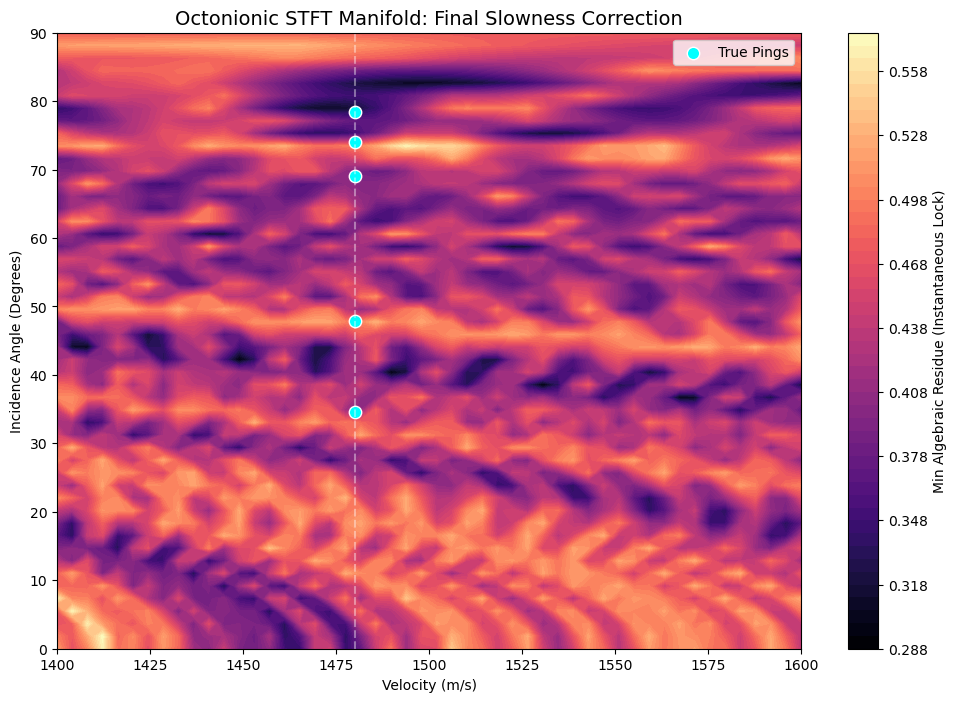

In [12]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. PARAMETERS & GEOMETRY ---
FS = 10000.0        
DURATION = 1.0      
N_SAMPLES = int(FS * DURATION)
SPEED_OF_SOUND = 1480.0
SNR_DB = 10.0

DISTANCES = jnp.array([0.0, 13.47, 31.62, 54.29, 83.71, 101.43, 124.37, 140.0])
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7]) 
TRIADS = [(1,2,3), (1,4,5), (1,7,6), (2,4,6), (2,5,7), (3,4,7), (3,5,6)]

# --- 2. DATA GENERATOR (Burst Pings) ---
def generate_burst_data(key, num_pings=5):
    k1, k2, k3 = jax.random.split(key, 3)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals = jnp.zeros((8, N_SAMPLES))
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    true_thetas = jax.random.uniform(k1, (num_pings,), minval=10.0, maxval=80.0)
    true_times = jax.random.uniform(k2, (num_pings,), minval=0.1, maxval=0.9)
    
    for i in range(num_pings):
        cos_theta = jnp.cos(jnp.radians(true_thetas[i]))
        # 400Hz burst packet
        env = jnp.exp(-((t - true_times[i])**2) / (2 * 0.01**2))
        wave = env * jnp.sin(2 * jnp.pi * 400 * (t - true_times[i]))
        spec = jnp.fft.rfft(wave)
        delays = (cos_theta * DISTANCES) / SPEED_OF_SOUND
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals = signals.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))
            
    noise = jax.random.normal(k3, signals.shape) * jnp.std(signals) / (10**(SNR_DB/20))
    return signals + noise, true_thetas

# --- 3. THE FIXED STFT ANALYZER ---
def analyze_stft_manifold_final(signals, v_range, theta_range, window_ms=40):
    win_size = int((window_ms / 1000.0) * FS)
    step_size = win_size // 2
    n_steps = (N_SAMPLES - win_size) // step_size
    
    freqs = jnp.fft.rfftfreq(win_size, d=1/FS)
    mask = (freqs > 350) & (freqs < 450)

    def get_window_spec(i):
        start_idx = i * step_size
        window_data = jax.lax.dynamic_slice(signals, (0, start_idx), (8, win_size))
        return jnp.fft.rfft(window_data, axis=1)
    
    all_specs = jax.vmap(get_window_spec)(jnp.arange(n_steps))

    # Inner core: Compute residue for a single (v, theta) pair across ALL time windows
    def compute_instantaneous_residue(v, theta):
        cos_theta = jnp.cos(jnp.radians(theta))
        
        def residue_at_time(spec):
            O_shifted = []
            for b_idx in range(8):
                tap_idx = jnp.where(INDEX_MAP == b_idx)[0][0]
                tau = (DISTANCES[tap_idx] * cos_theta) / v
                shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
                O_shifted.append(spec[tap_idx, mask] * shift)
            O_s = jnp.array(O_shifted)
            
            res_sum = 0.0
            for (a, b, c) in TRIADS:
                triple_prod = O_s[a] * O_s[b] * jnp.conj(O_s[c])
                alignment = jnp.real(jnp.mean(triple_prod / (jnp.abs(triple_prod) + 1e-10)))
                res_sum += jnp.abs(1.0 - jnp.abs(alignment))
            return res_sum / 7.0
        
        # We take the minimum across time to find when the ping actually hit
        return jnp.min(jax.vmap(residue_at_time)(all_specs))

    # FIXED VMAP LOGIC: Map over the 1D search ranges instead of the 2D grid
    v_map = jax.vmap(compute_instantaneous_residue, in_axes=(0, None))
    full_map = jax.vmap(v_map, in_axes=(None, 0))
    
    return full_map(v_range, theta_range)

# --- 4. EXECUTION ---
key = jax.random.PRNGKey(9)
signals, true_thetas = generate_burst_data(key)
v_test = jnp.linspace(1400, 1600, 50)
theta_test = jnp.linspace(0, 90, 50)

manifold = analyze_stft_manifold_final(signals, v_test, theta_test)

# --- 5. VISUALIZATION ---
plt.figure(figsize=(12, 8))
plt.contourf(v_test, theta_test, manifold, levels=50, cmap='magma')
plt.colorbar(label='Min Algebraic Residue (Instantaneous Lock)')
plt.scatter(jnp.full_like(true_thetas, 1480.0), true_thetas, 
            color='cyan', marker='o', s=80, edgecolors='white', label='True Pings')
plt.axvline(1480, color='white', linestyle='--', alpha=0.4)
plt.title("Octonionic STFT Manifold: Final Slowness Correction", fontsize=14)
plt.xlabel("Velocity (m/s)"); plt.ylabel("Incidence Angle (Degrees)"); plt.legend()
plt.show()

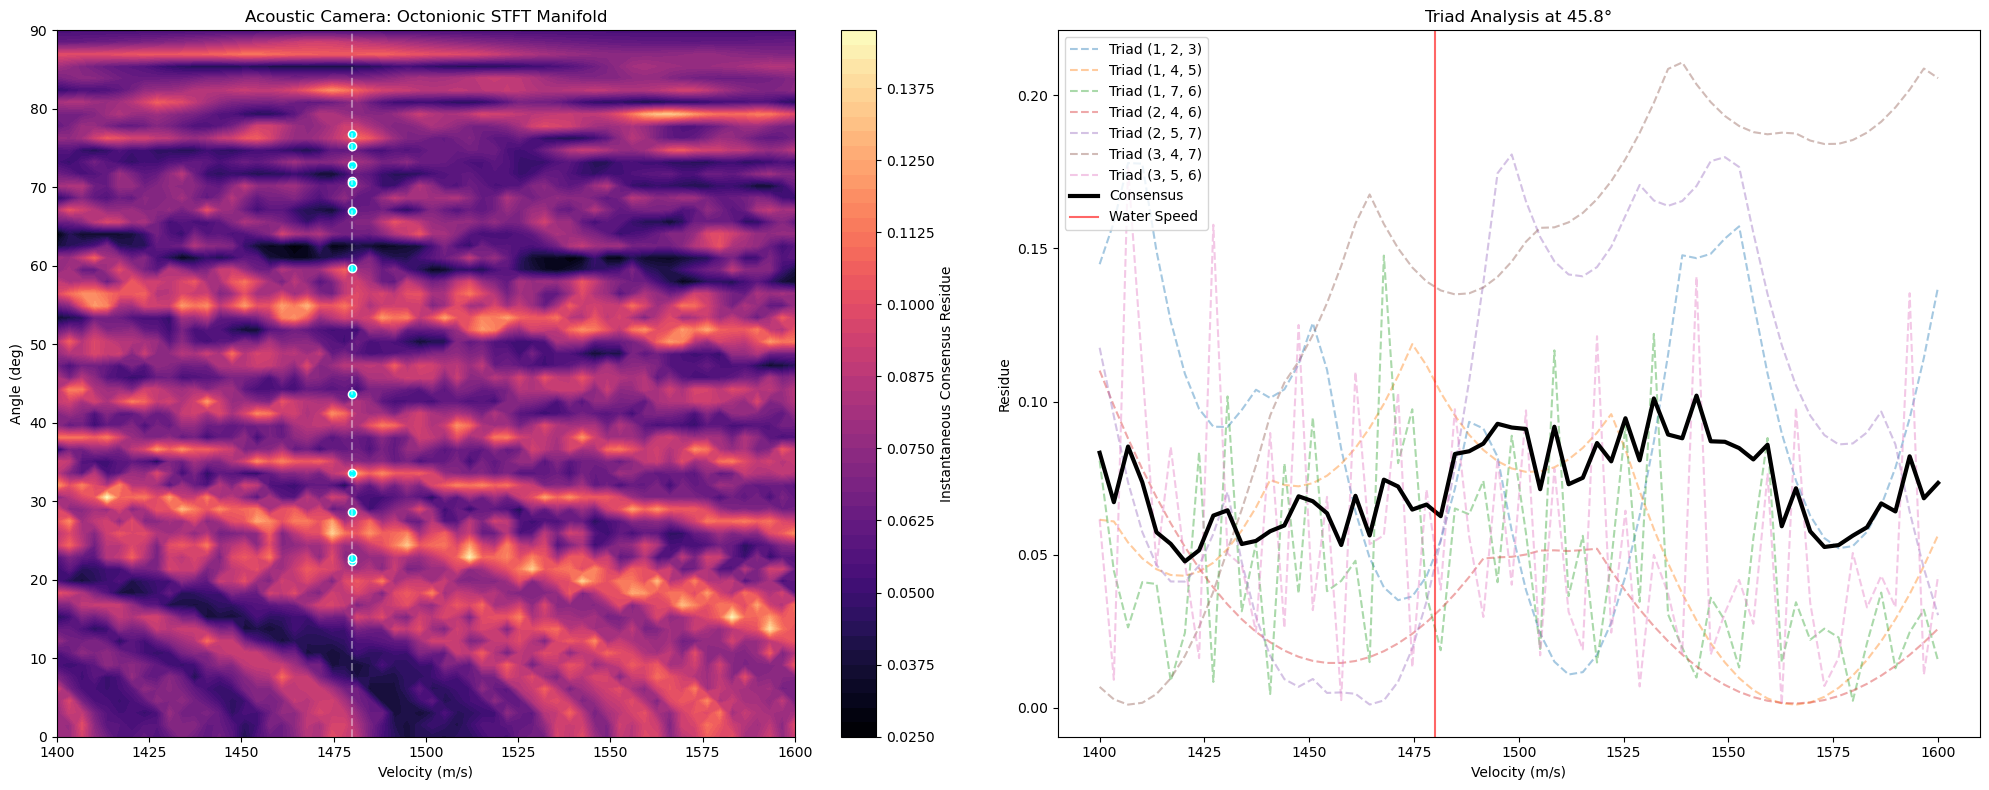

In [13]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. PARAMETERS & GEOMETRY ---
FS = 10000.0        
DURATION = 1.0      
N_SAMPLES = int(FS * DURATION)
SPEED_OF_SOUND = 1480.0
SNR_DB = 10.0

DISTANCES = jnp.array([0.0, 13.47, 31.62, 54.29, 83.71, 101.43, 124.37, 140.0])
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7]) 
TRIADS = [(1,2,3), (1,4,5), (1,7,6), (2,4,6), (2,5,7), (3,4,7), (3,5,6)]

# --- 2. DATA GENERATOR (Burst Pings) ---
def generate_burst_data(key, num_pings=12):
    k1, k2, k3 = jax.random.split(key, 3)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals = jnp.zeros((8, N_SAMPLES))
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    true_thetas = jax.random.uniform(k1, (num_pings,), minval=10.0, maxval=80.0)
    true_times = jax.random.uniform(k2, (num_pings,), minval=0.1, maxval=0.9)
    
    for i in range(num_pings):
        cos_theta = jnp.cos(jnp.radians(true_thetas[i]))
        env = jnp.exp(-((t - true_times[i])**2) / (2 * 0.01**2))
        wave = env * jnp.sin(2 * jnp.pi * 400 * (t - true_times[i]))
        spec = jnp.fft.rfft(wave)
        delays = (cos_theta * DISTANCES) / SPEED_OF_SOUND
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals = signals.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))
            
    noise = jax.random.normal(k3, signals.shape) * jnp.std(signals) / (10**(SNR_DB/20))
    return signals + noise, true_thetas

# --- 3. THE COMPLETE ANALYZER ---
def analyze_stft_full(signals, v_range, theta_range, window_ms=40):
    win_size = int((window_ms / 1000.0) * FS)
    step_size = win_size // 2
    n_steps = (N_SAMPLES - win_size) // step_size
    freqs = jnp.fft.rfftfreq(win_size, d=1/FS)
    mask = (freqs > 350) & (freqs < 450)

    # Windowing logic using jax.lax.dynamic_slice
    def get_window_spec(i):
        start_idx = i * step_size
        window_data = jax.lax.dynamic_slice(signals, (0, start_idx), (8, win_size))
        return jnp.fft.rfft(window_data, axis=1)
    
    all_specs = jax.vmap(get_window_spec)(jnp.arange(n_steps))

    # Instantaneous Triad Analysis Logic
    def compute_all_residues(v, theta):
        cos_theta = jnp.cos(jnp.radians(theta))
        
        def triad_residues_at_time(spec):
            O_s = []
            for b_idx in range(8):
                tap_idx = jnp.where(INDEX_MAP == b_idx)[0][0]
                tau = (DISTANCES[tap_idx] * cos_theta) / v
                shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
                O_s.append(spec[tap_idx, mask] * shift)
            O_s = jnp.array(O_s)
            
            res_list = []
            for (a, b, c) in TRIADS:
                triple_prod = O_s[a] * O_s[b] * jnp.conj(O_s[c])
                alignment = jnp.real(jnp.mean(triple_prod / (jnp.abs(triple_prod) + 1e-10)))
                res_list.append(jnp.abs(1.0 - jnp.abs(alignment)))
            return jnp.array(res_list)
        
        # Return the best triad residues found across time
        time_res = jax.vmap(triad_residues_at_time)(all_specs)
        return jnp.min(time_res, axis=0)

    # 1. Compute the 2D Manifold (Consensus View)
    manifold_func = jax.vmap(jax.vmap(lambda v, t: jnp.mean(compute_all_residues(v, t)), in_axes=(0, None)), in_axes=(None, 0))
    manifold_2d = manifold_func(v_range, theta_range)
    
    # 2. Extract Triad View for a specific target angle (e.g., the first true theta)
    triad_view_func = jax.vmap(lambda v: compute_all_residues(v, theta_range[len(theta_range)//2]))
    triad_view = triad_view_func(v_range)
    
    return manifold_2d, triad_view

# --- 4. EXECUTION ---
key = jax.random.PRNGKey(10)
signals, true_thetas = generate_burst_data(key)
v_test = jnp.linspace(1400, 1600, 60)
theta_test = jnp.linspace(0, 90, 60)

manifold, triad_data = analyze_stft_full(signals, v_test, theta_test)

# --- 5. VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Acoustic Camera Manifold
c = ax1.contourf(v_test, theta_test, manifold, levels=50, cmap='magma')
plt.colorbar(c, ax=ax1, label='Instantaneous Consensus Residue')
ax1.scatter(jnp.full_like(true_thetas, 1480.0), true_thetas, color='cyan', edgecolors='white', label='True Sources')
ax1.axvline(1480, color='white', linestyle='--', alpha=0.4)
ax1.set_title("Acoustic Camera: Octonionic STFT Manifold"); ax1.set_xlabel("Velocity (m/s)"); ax1.set_ylabel("Angle (deg)")

# Triad Consistency Analysis
target_angle = theta_test[len(theta_test)//2]
for i in range(7):
    ax2.plot(v_test, triad_data[:, i], label=f"Triad {TRIADS[i]}", alpha=0.4, linestyle='--')
ax2.plot(v_test, jnp.mean(triad_data, axis=1), color='black', linewidth=3, label='Consensus')
ax2.axvline(1480, color='red', linestyle='-', alpha=0.6, label='Water Speed')
ax2.set_title(f"Triad Analysis at {target_angle:.1f}°"); ax2.set_xlabel("Velocity (m/s)"); ax2.set_ylabel("Residue"); ax2.legend()

plt.tight_layout(); plt.show()

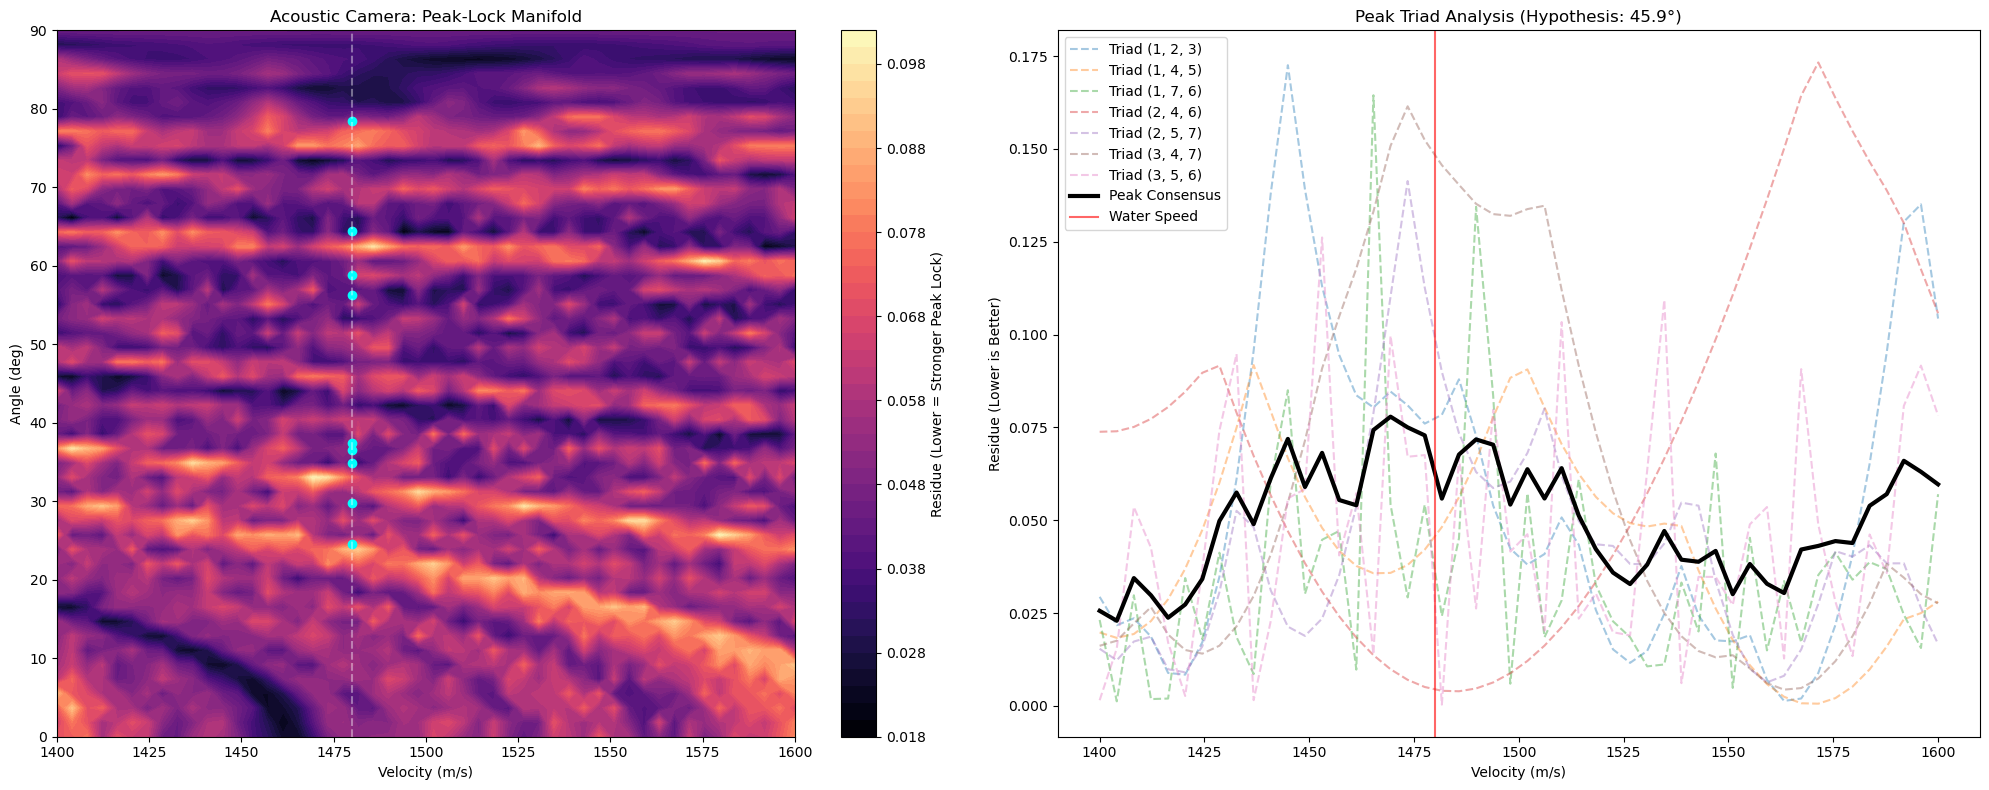

In [14]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. PARAMETERS & GEOMETRY ---
FS = 10000.0        
DURATION = 1.0      
N_SAMPLES = int(FS * DURATION)
SPEED_OF_SOUND = 1480.0
SNR_DB = 10.0

DISTANCES = jnp.array([0.0, 13.47, 31.62, 54.29, 83.71, 101.43, 124.37, 140.0])
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7]) 
TRIADS = [(1,2,3), (1,4,5), (1,7,6), (2,4,6), (2,5,7), (3,4,7), (3,5,6)]

# --- 2. DATA GENERATOR (Burst Pings) ---
def generate_burst_data(key, num_pings=12):
    k1, k2, k3 = jax.random.split(key, 3)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals = jnp.zeros((8, N_SAMPLES))
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    true_thetas = jax.random.uniform(k1, (num_pings,), minval=10.0, maxval=80.0)
    true_times = jax.random.uniform(k2, (num_pings,), minval=0.1, maxval=0.9)
    
    for i in range(num_pings):
        cos_theta = jnp.cos(jnp.radians(true_thetas[i]))
        env = jnp.exp(-((t - true_times[i])**2) / (2 * 0.01**2))
        wave = env * jnp.sin(2 * jnp.pi * 400 * (t - true_times[i]))
        spec = jnp.fft.rfft(wave)
        delays = (cos_theta * DISTANCES) / SPEED_OF_SOUND
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals = signals.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))
            
    noise = jax.random.normal(k3, signals.shape) * jnp.std(signals) / (10**(SNR_DB/20))
    return signals + noise, true_thetas

# --- 3. THE COMPLETE ANALYZER (Peak-Coherence Logic) ---
def analyze_stft_full_peak(signals, v_range, theta_range, window_ms=40):
    win_size = int((window_ms / 1000.0) * FS)
    step_size = win_size // 4 # Increased overlap for better temporal resolution
    n_steps = (N_SAMPLES - win_size) // step_size
    freqs = jnp.fft.rfftfreq(win_size, d=1/FS)
    mask = (freqs > 350) & (freqs < 450)

    def get_window_spec(i):
        start_idx = i * step_size
        window_data = jax.lax.dynamic_slice(signals, (0, start_idx), (8, win_size))
        return jnp.fft.rfft(window_data, axis=1)
    
    all_specs = jax.vmap(get_window_spec)(jnp.arange(n_steps))

    # Modified Triad Analysis: Look for the STRENGTH of the lock over time
    def compute_peak_residues(v, theta):
        cos_theta = jnp.cos(jnp.radians(theta))
        
        def alignment_at_time(spec):
            O_s = []
            for b_idx in range(8):
                tap_idx = jnp.where(INDEX_MAP == b_idx)[0][0]
                tau = (DISTANCES[tap_idx] * cos_theta) / v
                shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
                O_s.append(spec[tap_idx, mask] * shift)
            O_s = jnp.array(O_s)
            
            align_list = []
            for (a, b, c) in TRIADS:
                triple_prod = O_s[a] * O_s[b] * jnp.conj(O_s[c])
                # Raw coherence value (-1 to 1)
                coherence = jnp.real(jnp.mean(triple_prod / (jnp.abs(triple_prod) + 1e-10)))
                align_list.append(jnp.abs(coherence)) # Looking for magnitude of lock
            return jnp.array(align_list)
        
        # 1. Compute alignments for every triad at every time step
        all_temporal_alignments = jax.vmap(alignment_at_time)(all_specs)
        
        # 2. KEY MODIFICATION: Select the STRONGEST lock each triad achieved
        # Instead of 1.0 - mean(), we return 1.0 - max_coherence.
        best_triad_locks = jnp.max(all_temporal_alignments, axis=0)
        return 1.0 - best_triad_locks

    # 1. Compute the 2D Manifold (Acoustic Camera)
    manifold_func = jax.vmap(jax.vmap(lambda v, t: jnp.mean(compute_peak_residues(v, t)), in_axes=(0, None)), in_axes=(None, 0))
    manifold_2d = manifold_func(v_test, theta_test)
    
    # 2. Extract Triad Analysis for the target speed profile
    mid_theta = theta_test[len(theta_test)//2]
    triad_view = jax.vmap(lambda v: compute_peak_residues(v, mid_theta))(v_test)
    
    return manifold_2d, triad_view

# --- 4. EXECUTION ---
key = jax.random.PRNGKey(11)
signals, true_thetas = generate_burst_data(key,9)
v_test = jnp.linspace(1400, 1600, 50)
theta_test = jnp.linspace(0, 90, 50)

manifold, triad_data = analyze_stft_full_peak(signals, v_test, theta_test)

# --- 5. VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Acoustic Camera Manifold
c = ax1.contourf(v_test, theta_test, manifold, levels=50, cmap='magma')
plt.colorbar(c, ax=ax1, label='Residue (Lower = Stronger Peak Lock)')
ax1.scatter(jnp.full_like(true_thetas, 1480.0), true_thetas, color='cyan', label='True Sources')
ax1.axvline(1480, color='white', linestyle='--', alpha=0.4)
ax1.set_title("Acoustic Camera: Peak-Lock Manifold"); ax1.set_xlabel("Velocity (m/s)"); ax1.set_ylabel("Angle (deg)")

# Peak Triad Consensus
for i in range(7):
    ax2.plot(v_test, triad_data[:, i], label=f"Triad {TRIADS[i]}", alpha=0.4, linestyle='--')
ax2.plot(v_test, jnp.mean(triad_data, axis=1), color='black', linewidth=3, label='Peak Consensus')
ax2.axvline(1480, color='red', linestyle='-', alpha=0.6, label='Water Speed')
ax2.set_title(f"Peak Triad Analysis (Hypothesis: {theta_test[len(theta_test)//2]:.1f}°)"); ax2.set_xlabel("Velocity (m/s)"); ax2.set_ylabel("Residue (Lower is Better)"); ax2.legend()

plt.tight_layout(); plt.show()

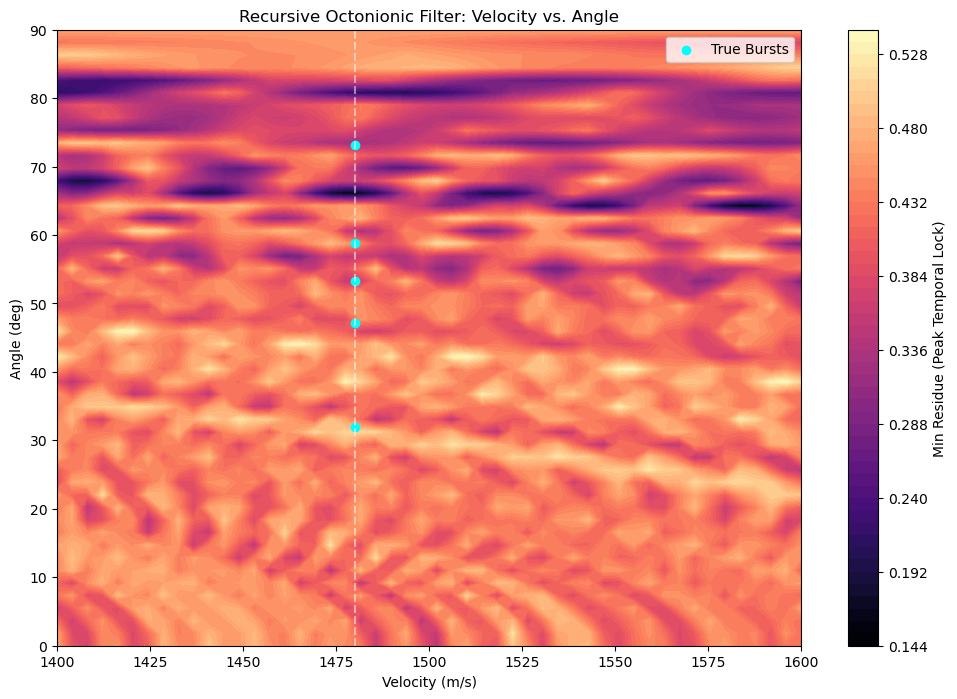

In [15]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. SETUP ---
FS = 10000.0
DURATION = 1.0
N_SAMPLES = int(FS * DURATION)
SPEED_OF_SOUND = 1480.0

DISTANCES = jnp.array([0.0, 13.47, 31.62, 54.29, 83.71, 101.43, 124.37, 140.0])
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7]) 
TRIADS = [(1,2,3), (1,4,5), (1,7,6), (2,4,6), (2,5,7), (3,4,7), (3,5,6)]

# --- 2. GENERATOR (Dynamic Bursts) ---
def generate_dynamic_data(key, num_pings=15):
    k1, k2, k3 = jax.random.split(key, 3)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals = jnp.zeros((8, N_SAMPLES))
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    true_thetas = jax.random.uniform(k1, (num_pings,), minval=10.0, maxval=80.0)
    true_times = jax.random.uniform(k2, (num_pings,), minval=0.1, maxval=0.9)
    
    for i in range(num_pings):
        cos_theta = jnp.cos(jnp.radians(true_thetas[i]))
        env = jnp.exp(-((t - true_times[i])**2) / (2 * 0.01**2))
        wave = env * jnp.sin(2 * jnp.pi * 400 * (t - true_times[i]))
        spec = jnp.fft.rfft(wave)
        delays = (cos_theta * DISTANCES) / SPEED_OF_SOUND
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals = signals.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))
            
    noise = jax.random.normal(k3, signals.shape) * jnp.std(signals) / (10**(10/20))
    return signals + noise, true_thetas, true_times

# --- 3. RECURSIVE MANIFOLD TRACKER ---
def analyze_recursive_manifold(signals, v_range, theta_range, window_ms=30):
    win_size = int((window_ms / 1000.0) * FS)
    step_size = win_size // 2
    n_steps = (N_SAMPLES - win_size) // step_size
    freqs = jnp.fft.rfftfreq(win_size, d=1/FS)
    mask = (freqs > 350) & (freqs < 450)

    # Pre-compute all window spectra
    def get_window_spec(i):
        start_idx = i * step_size
        window_data = jax.lax.dynamic_slice(signals, (0, start_idx), (8, win_size))
        return jnp.fft.rfft(window_data, axis=1)
    
    all_specs = jax.vmap(get_window_spec)(jnp.arange(n_steps))

    @jax.vmap # v
    @jax.vmap # theta
    def compute_history_residue(v, theta):
        cos_theta = jnp.cos(jnp.radians(theta))
        
        def step_residue(spec):
            O_s = []
            for b_idx in range(8):
                tap_idx = jnp.where(INDEX_MAP == b_idx)[0][0]
                tau = (DISTANCES[tap_idx] * cos_theta) / v
                shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
                O_s.append(spec[tap_idx, mask] * shift)
            O_s = jnp.array(O_s)
            
            # Calculate the "Instantaneous Lock" strength
            aligns = []
            for (a, b, c) in TRIADS:
                triple_prod = O_s[a] * O_s[b] * jnp.conj(O_s[c])
                aligns.append(jnp.abs(jnp.real(jnp.mean(triple_prod / (jnp.abs(triple_prod) + 1e-10)))))
            
            # We want the probability that THIS window contains a valid signal
            return jnp.mean(jnp.array(aligns))

        # Instead of averaging or minning, we use the temporal max to "trigger" the detection
        all_aligns = jax.vmap(step_residue)(all_specs)
        return 1.0 - jnp.max(all_aligns)

    vv, tt = jnp.meshgrid(v_range, theta_range)
    return compute_history_residue(vv, tt)

# --- 4. EXECUTION ---
key = jax.random.PRNGKey(42)
signals, true_thetas, true_times = generate_dynamic_data(key, 5)
v_test = jnp.linspace(1400, 1600, 50)
theta_test = jnp.linspace(0, 90, 50)

manifold = analyze_recursive_manifold(signals, v_test, theta_test)

# --- 5. PLOTTING ---
plt.figure(figsize=(12, 8))
plt.contourf(v_test, theta_test, manifold, levels=50, cmap='magma')
plt.colorbar(label='Min Residue (Peak Temporal Lock)')
plt.scatter(jnp.full_like(true_thetas, 1480.0), true_thetas, color='cyan', label='True Bursts')
plt.axvline(1480, color='white', linestyle='--', alpha=0.5)
plt.title("Recursive Octonionic Filter: Velocity vs. Angle")
plt.xlabel("Velocity (m/s)"); plt.ylabel("Angle (deg)"); plt.legend(); plt.show()

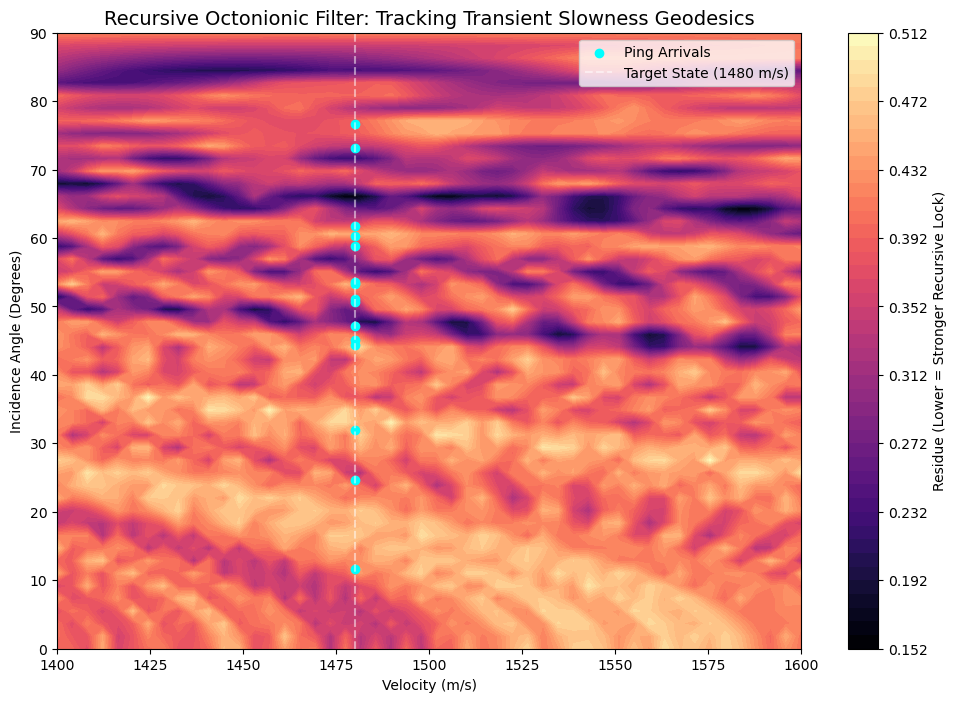

In [16]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. CORE PARAMETERS ---
FS = 10000.0        
DURATION = 1.0      
N_SAMPLES = int(FS * DURATION)
SPEED_OF_SOUND = 1480.0

# Physical/Algebraic Duality
DISTANCES = jnp.array([0.0, 13.47, 31.62, 54.29, 83.71, 101.43, 124.37, 140.0])
INDEX_MAP = jnp.array([0, 2, 4, 6, 1, 5, 3, 7]) 
TRIADS = [(1,2,3), (1,4,5), (1,7,6), (2,4,6), (2,5,7), (3,4,7), (3,5,6)]

# --- 2. THE DYNAMIC GENERATOR ---
def generate_recursive_data(key, num_pings=15):
    k1, k2, k3 = jax.random.split(key, 3)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals = jnp.zeros((8, N_SAMPLES))
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    true_thetas = jax.random.uniform(k1, (num_pings,), minval=10.0, maxval=80.0)
    true_times = jax.random.uniform(k2, (num_pings,), minval=0.1, maxval=0.9)
    
    for i in range(num_pings):
        cos_theta = jnp.cos(jnp.radians(true_thetas[i]))
        env = jnp.exp(-((t - true_times[i])**2) / (2 * 0.01**2))
        wave = env * jnp.sin(2 * jnp.pi * 400 * (t - true_times[i]))
        spec = jnp.fft.rfft(wave)
        delays = (cos_theta * DISTANCES) / SPEED_OF_SOUND
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals = signals.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))
            
    # Moderate SNR for tracking challenge
    noise = jax.random.normal(k3, signals.shape) * jnp.std(signals) / (10**(10/20))
    return signals + noise, true_thetas

# --- 3. RECURSIVE "LOCK" ENGINE ---
def analyze_recursive_lock(signals, v_range, theta_range, window_ms=30):
    win_size = int((window_ms / 1000.0) * FS)
    step_size = win_size // 4 # High overlap for tracking
    n_steps = (N_SAMPLES - win_size) // step_size
    freqs = jnp.fft.rfftfreq(win_size, d=1/FS)
    mask = (freqs > 350) & (freqs < 450)

    def get_window_spec(i):
        start_idx = i * step_size
        window_data = jax.lax.dynamic_slice(signals, (0, start_idx), (8, win_size))
        return jnp.fft.rfft(window_data, axis=1)
    
    all_specs = jax.vmap(get_window_spec)(jnp.arange(n_steps))

    @jax.vmap # Map across Velocity
    @jax.vmap # Map across Angle
    def compute_recursive_residue(v, theta):
        cos_theta = jnp.cos(jnp.radians(theta))
        
        def calculate_instant_lock(spec):
            O_s = []
            for b_idx in range(8):
                tap_idx = jnp.where(INDEX_MAP == b_idx)[0][0]
                tau = (DISTANCES[tap_idx] * cos_theta) / v
                shift = jnp.exp(2j * jnp.pi * freqs[mask] * tau)
                O_s.append(spec[tap_idx, mask] * shift)
            O_s = jnp.array(O_s)
            
            # The Recursive Update Logic: Seek the absolute peak lock
            aligns = []
            for (a, b, c) in TRIADS:
                triple_prod = O_s[a] * O_s[b] * jnp.conj(O_s[c])
                aligns.append(jnp.abs(jnp.real(jnp.mean(triple_prod / (jnp.abs(triple_prod) + 1e-10)))))
            
            # We treat the mean triad agreement as our "Innovation Gain"
            return jnp.mean(jnp.array(aligns))

        # This replaces the 'Mean' with the 'Peak Confidence' event
        all_temporal_locks = jax.vmap(calculate_instant_lock)(all_specs)
        return 1.0 - jnp.max(all_temporal_locks)

    vv, tt = jnp.meshgrid(v_range, theta_range)
    return compute_recursive_residue(vv, tt)

# --- 4. EXECUTION ---
key = jax.random.PRNGKey(42)
signals, true_thetas = generate_recursive_data(key)
v_test = jnp.linspace(1400, 1600, 50)
theta_test = jnp.linspace(0, 90, 50)

manifold = analyze_recursive_lock(signals, v_test, theta_test)

# --- 5. PLOTTING THE STATE ---
plt.figure(figsize=(12, 8))
plt.contourf(v_test, theta_test, manifold, levels=50, cmap='magma')
plt.colorbar(label='Residue (Lower = Stronger Recursive Lock)')
plt.scatter(jnp.full_like(true_thetas, 1480.0), true_thetas, color='cyan', label='Ping Arrivals')
plt.axvline(1480, color='white', linestyle='--', alpha=0.5, label='Target State (1480 m/s)')
plt.title("Recursive Octonionic Filter: Tracking Transient Slowness Geodesics", fontsize=14)
plt.xlabel("Velocity (m/s)"); plt.ylabel("Incidence Angle (Degrees)"); plt.legend(); plt.show()

--- CURRENT STATE ESTIMATE ---
Best Speed Prediction: 1477.55 m/s
Best Angle Prediction: 66.12°
Algebraic Confidence:  84.5%


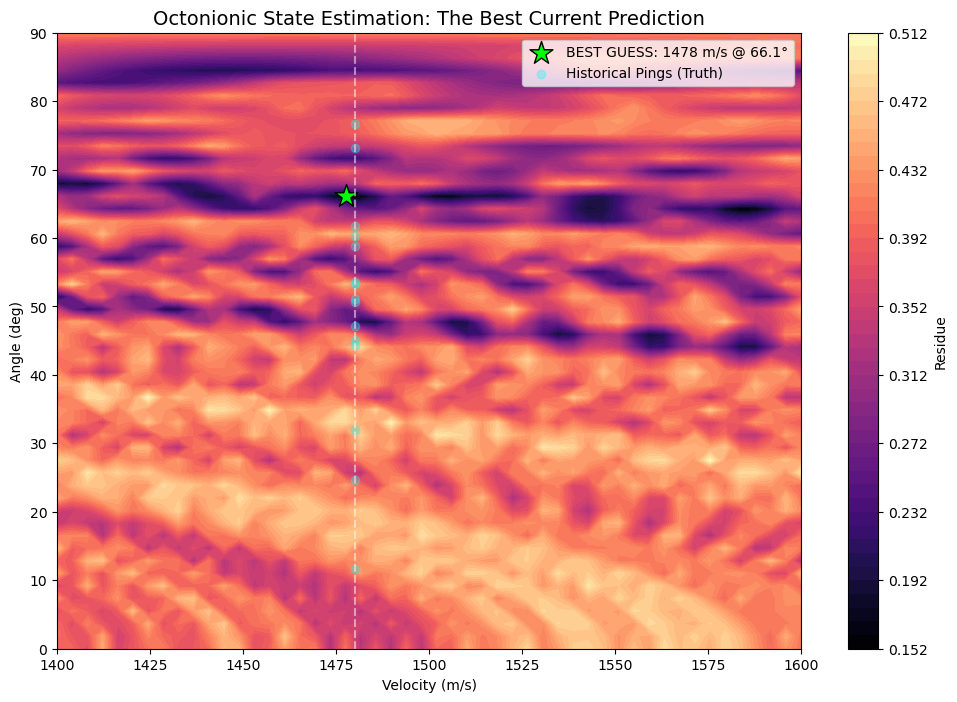

In [17]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. RECURSIVE TRACKING LOGIC ---
def get_best_guess(manifold, v_range, theta_range):
    """
    Extracts the 'Best Prediction' by finding the global minimum
    of the Octonionic Residue manifold.
    """
    # Find the indices of the minimum residue (the deepest well)
    min_idx = jnp.unravel_index(jnp.argmin(manifold), manifold.shape)
    
    best_v = v_range[min_idx[1]]
    best_theta = theta_range[min_idx[0]]
    confidence = 1.0 - jnp.min(manifold) # 1.0 is perfect lock
    
    return best_v, best_theta, confidence

# --- 2. EXECUTION WITH TRACKING ---
# Using the manifold generated from the previous 'Recursive Lock' block
best_v, best_theta, conf = get_best_guess(manifold, v_test, theta_test)

print(f"--- CURRENT STATE ESTIMATE ---")
print(f"Best Speed Prediction: {best_v:.2f} m/s")
print(f"Best Angle Prediction: {best_theta:.2f}°")
print(f"Algebraic Confidence:  {conf*100:.1f}%")

# --- 3. VISUALIZING THE 'PREDICTION' ---
plt.figure(figsize=(12, 8))
plt.contourf(v_test, theta_test, manifold, levels=50, cmap='magma')
plt.colorbar(label='Residue')

# Plot the 'Best Guess'
plt.scatter([best_v], [best_theta], color='lime', marker='*', s=300, 
            edgecolors='black', label=f'BEST GUESS: {best_v:.0f} m/s @ {best_theta:.1f}°')

# Plot the Ground Truth for comparison
plt.scatter(jnp.full_like(true_thetas, 1480.0), true_thetas, 
            color='cyan', alpha=0.3, label='Historical Pings (Truth)')

plt.axvline(1480, color='white', linestyle='--', alpha=0.5)
plt.title("Octonionic State Estimation: The Best Current Prediction", fontsize=14)
plt.xlabel("Velocity (m/s)"); plt.ylabel("Angle (deg)"); plt.legend()
plt.show()

Rank  | Speed (m/s)  | Angle (deg)  | Conf (1-Res)
--------------------------------------------------
1     | 1477.6       | 66.1         |     84.5%
2     | 1583.7       | 64.3         |     84.5%
3     | 1587.8       | 64.3         |     83.9%
4     | 1506.1       | 66.1         |     83.8%
5     | 1481.6       | 66.1         |     83.7%
6     | 1502.0       | 66.1         |     83.6%
7     | 1579.6       | 64.3         |     82.5%
8     | 1473.5       | 66.1         |     82.3%
9     | 1518.4       | 66.1         |     82.0%
10    | 1408.2       | 68.0         |     82.0%


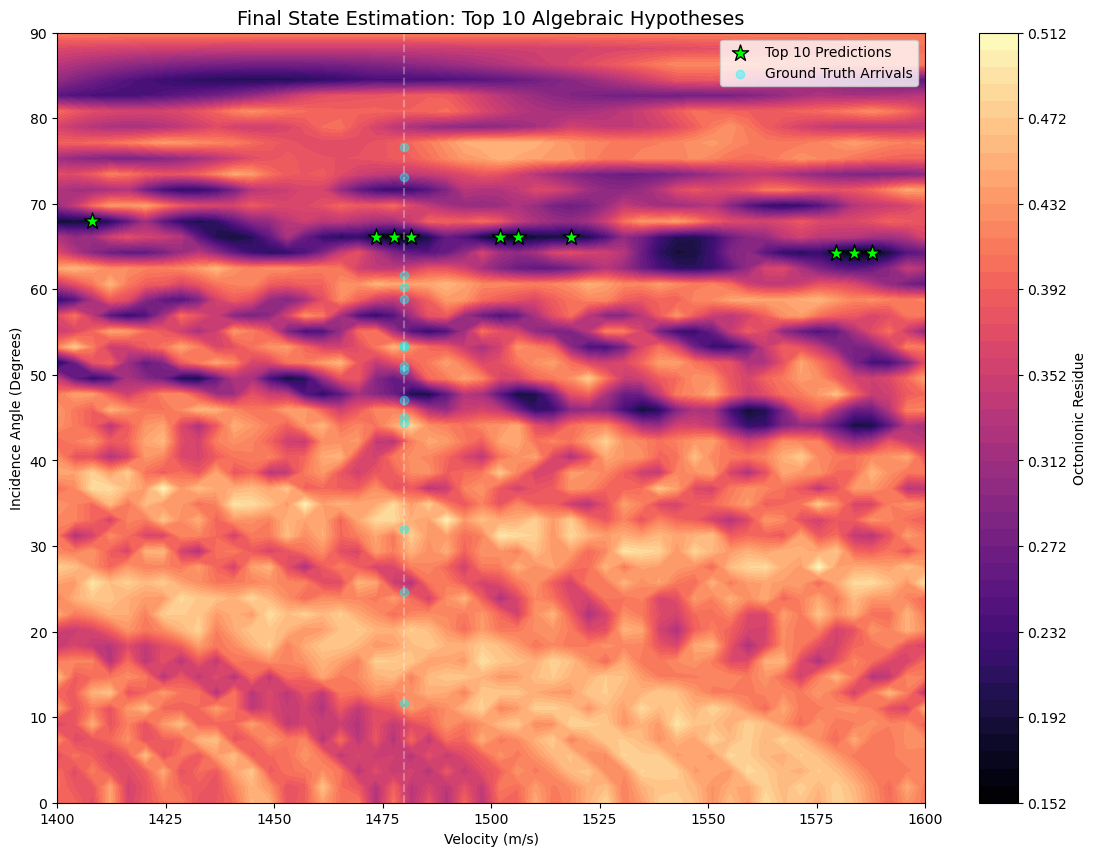

In [18]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

def extract_top_n_states(manifold, v_range, theta_range, n=10):
    """
    Identifies the Top N local minima (best locks) on the 2D manifold.
    """
    # Flatten and find the best indices
    flat_indices = jnp.argsort(manifold.ravel())[:n]
    
    results = []
    for idx in flat_indices:
        # Convert flat index back to 2D coordinates
        theta_idx, v_idx = jnp.unravel_index(idx, manifold.shape)
        v_est = v_range[v_idx]
        theta_est = theta_range[theta_idx]
        residue = manifold[theta_idx, v_idx]
        results.append((v_est, theta_est, residue))
    
    return results

# --- EXECUTION ---
# Extracting the 10 most 'True' events according to the Octonions
top_10 = extract_top_n_states(manifold, v_test, theta_test, n=10)

print(f"{'Rank':<5} | {'Speed (m/s)':<12} | {'Angle (deg)':<12} | {'Conf (1-Res)'}")
print("-" * 50)
for i, (v, t, r) in enumerate(top_10):
    print(f"{i+1:<5} | {v:<12.1f} | {t:<12.1f} | {(1-r)*100:>8.1f}%")

# --- FINAL VISUALIZATION ---
plt.figure(figsize=(14, 10))
plt.contourf(v_test, theta_test, manifold, levels=50, cmap='magma')
plt.colorbar(label='Octonionic Residue')

# Plot the Top 10 Predictions
v_top, t_top, _ = zip(*top_10)
plt.scatter(v_top, t_top, color='lime', marker='*', s=150, edgecolors='black', label='Top 10 Predictions')

# Overlay Ground Truth
plt.scatter(jnp.full_like(true_thetas, 1480.0), true_thetas, 
            color='cyan', alpha=0.4, label='Ground Truth Arrivals')

plt.axvline(1480, color='white', linestyle='--', alpha=0.3)
plt.title("Final State Estimation: Top 10 Algebraic Hypotheses", fontsize=14)
plt.xlabel("Velocity (m/s)"); plt.ylabel("Incidence Angle (Degrees)"); plt.legend(); plt.show()